# Bias vs. Lead Time Plots

plotting the differnece between the AI forecast (Pangu-Weather) and ERA5 2 meter temperature reanalysis data as a function of of lead time.

These are global biases for now, but the intention is to focus on regions with higher biases and/or regions prone to/historically deal with sever weather/heat waves.

## Imports

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# Direct access
import s3fs

# datetime
import datetime as dt

# api to read files
import dask.array as da
import xarray as xr
import h5py

# data process
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import cartopy.crs as ccrs
import cartopy.feature as cfeature

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Access AWS servers and read in Pangu data

In [3]:
days = 10 
dd_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

s3 = s3fs.S3FileSystem(anon=True) # connect to s3

lon_list = []
lat_list = []
t2_list = []
time_list = []

for day in range(days):
    url_parents = 's3://noaa-oar-mlwp-data' 
    model = 'PANG_v100'
    yyyy = '2023'
    mm = '07'
    dd = dd_list[day]
    url_radar_search = url_parents +'/'+model+'/' +yyyy + '/' + mm + dd + '/'   
    
    url_radar_date = s3.ls(url_radar_search) # list all the files in the folder
    
    aws_file = 's3://' + url_radar_date[0]
    
    f = s3.open(aws_file, 'rb') # open the file
    
    ds = xr.open_dataset(f, chunks={'time': 10, 'lat': 50, 'lon': 50}, engine='h5netcdf') # read the file

    lon = ds.variables['longitude'][:]
    lon_list.append(lon)
    
    lat = ds.variables['latitude'][:]
    lat_list.append(lat)
    
    t2_PANG = ds.variables['t2'][:]
    t2_list.append(t2_PANG)
    
    time = ds.variables['time'][:]
    time_list.append(time)
    

In [4]:
time_list[5][16] # test to check if i loaded the data correctly, should read 2023-07-10 00 UTC

<xarray.Variable ()>
array('2023-07-10T00:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    long_name:  Date and Time

## ERA5 Reanalysis Data

In [5]:
era5_ds = xr.open_dataset('ERA5_data/20230701.part')
lon_era = era5_ds.variables['longitude'][:]
lat_era = era5_ds.variables['latitude'][:]
t2_ERA5 = era5_ds.variables['t2m'][36,:,:]
era_time =  era5_ds.variables['time'][36]
t2_ERA5

<xarray.Variable (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Attributes:
    units:      K
    long_name:  2 metre temperature

In [6]:
datetime = pd.to_datetime(time_list[0].data, unit='s')
datetime

DatetimeIndex(['2023-07-01 00:00:00', '2023-07-01 06:00:00',
               '2023-07-01 12:00:00', '2023-07-01 18:00:00',
               '2023-07-02 00:00:00', '2023-07-02 06:00:00',
               '2023-07-02 12:00:00', '2023-07-02 18:00:00',
               '2023-07-03 00:00:00', '2023-07-03 06:00:00',
               '2023-07-03 12:00:00', '2023-07-03 18:00:00',
               '2023-07-04 00:00:00', '2023-07-04 06:00:00',
               '2023-07-04 12:00:00', '2023-07-04 18:00:00',
               '2023-07-05 00:00:00', '2023-07-05 06:00:00',
               '2023-07-05 12:00:00', '2023-07-05 18:00:00',
               '2023-07-06 00:00:00', '2023-07-06 06:00:00',
               '2023-07-06 12:00:00', '2023-07-06 18:00:00',
               '2023-07-07 00:00:00', '2023-07-07 06:00:00',
               '2023-07-07 12:00:00', '2023-07-07 18:00:00',
               '2023-07-08 00:00:00', '2023-07-08 06:00:00',
               '2023-07-08 12:00:00', '2023-07-08 18:00:00',
               '2023-07-

## Plots

In [24]:
# creating lead time markers for plot
LT_list = []
for day in range(days):
    LT = datetime[4*day]
    LT_list.append(LT)

In [25]:
# Calculate biases
bias_list = []
for day in range(days):
    bias = t2_list[day][36-(4*day)] - t2_ERA5
    bias_list.append(bias)

# Calculate average bias and variance
avg_bias_list = [np.mean(bias) for bias in bias_list]
var_bias_list = [np.var(bias) for bias in bias_list]

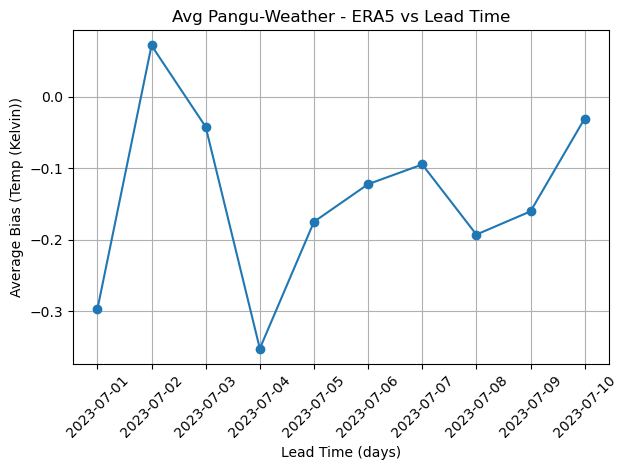

In [26]:
# Plot average bias
plt.figure()
plt.plot(LT_list, avg_bias_list, marker='o')
plt.xlabel('Lead Time (days)')
plt.ylabel('Average Bias (Temp (Kelvin))')
plt.title('Avg Pangu-Weather - ERA5 vs Lead Time')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

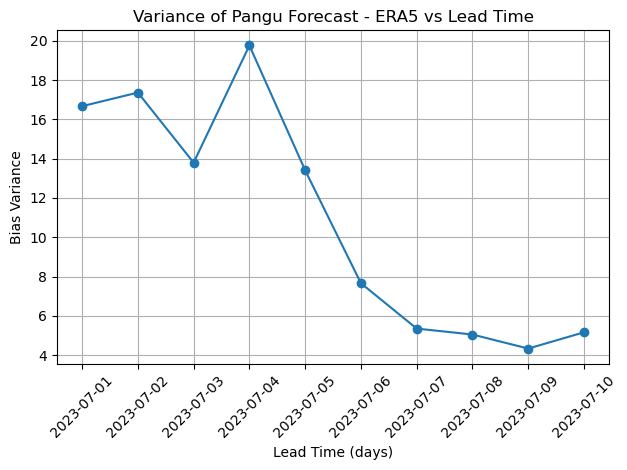

In [27]:
# Plot variance of bias
plt.figure()
plt.plot(LT_list, var_bias_list, marker='o')
plt.xlabel('Lead Time (days)')
plt.ylabel('Bias Variance')
plt.title('Variance of Pangu Forecast - ERA5 vs Lead Time')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [30]:
rmse_list = []
for day in range(days):
    rmse = np.sqrt((np.mean(t2_list[day][36-(4*day),:,:], t2_ERA5))**2)
    rmse_list.append(rmse)
    
rmse_list

ValueError: operands could not be broadcast together with shapes (721,1440) (0,) 

### Figures to Pangu-Weather July 1st 2023 prediction of july 10 2023 

The idea is to create a subplot with the two figures you see below as a supplement to the plots from above.

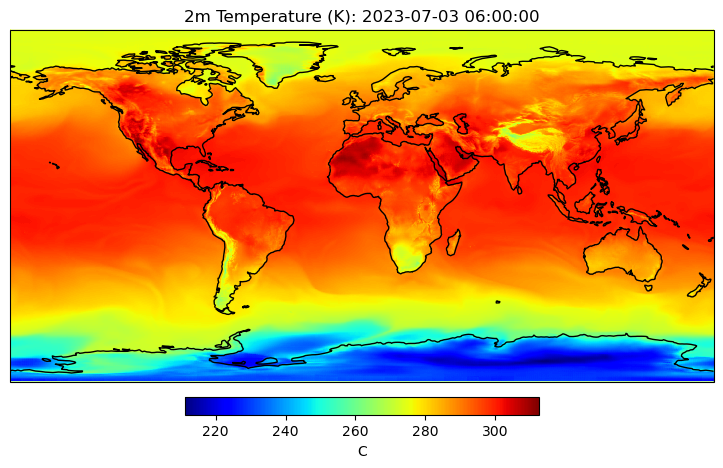

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
# ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')

# Create the contour plot with the 'jet' colormap
contour = ax.pcolormesh(lon, lat, t2_list[0][36,:,:], cmap='jet', transform=ccrs.PlateCarree())

# Add the colorbar and set the label
cbar = plt.colorbar(contour,orientation='horizontal',
                    # cax=cbar_ax, 
                    fraction=0.046, pad=0.04)
cbar.set_label('K')
# set the sized of the colorbar
# cbar.ax.tick_params(labelsize=20)

plt.title(f'2m Temperature (K): {str(datetime[9])}')
plt.show()

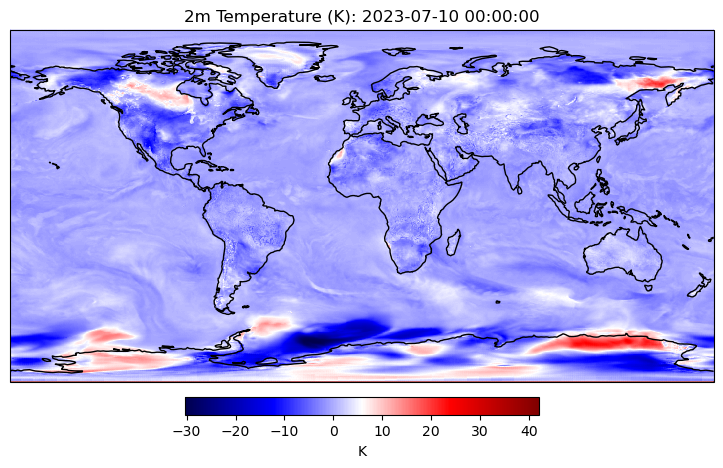

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Create the contour plot with the 'jet' colormap
contour = ax.pcolormesh(lon, lat, bias_list[0], cmap='seismic', transform=ccrs.PlateCarree())

# Add the colorbar and set the label
cbar = plt.colorbar(contour,orientation='horizontal',
                    # cax=cbar_ax, 
                    fraction=0.046, pad=0.04)
cbar.set_label('K')
# set the sized of the colorbar
# cbar.ax.tick_params(labelsize=20)

plt.title(f'2m Temperature (K): {str(datetime[36])}')
plt.show()